# 3 Trajectory processing using TransBigData


For vehicle trajectory data, the TransBigData library provides a comprehensive set of trajectory data processing methods starting from version 0.5.0 and above. These methods include preprocessing and drift correction of trajectory data, segmentation of stops and trips, grid-based representation, visualization, and more. This article will introduce how to use the TransBigData library for processing trajectory data.

In [1]:
import pandas as pd
import geopandas as gpd
import transbigdata as tbd
# ensure tbd version is above 0.5.0
tbd.__version__

'0.5.0'

## Trajectory Quality
First, we read the data and observe the basic information to check for any missing values. Using the built-in methods of a DataFrame, we can easily view the basic information of the data, including data types, number of fields, number of rows, and the presence of missing values. The code is as follows:


In [2]:
# Read the data
data = pd.read_csv('data/TaxiData-Sample.csv', header=None)
data.columns = ['id', 'time', 'lon', 'lat', 'OpenStatus', 'speed']
# Convert the time format
data['time'] = pd.to_datetime(data['time'])
data

,id,time,lon,lat,OpenStatus,speed
0,34745,2023-05-29 20:27:43,113.806847,22.623249,1,27
1,34745,2023-05-29 20:24:07,113.809898,22.627399,0,0
2,34745,2023-05-29 20:24:27,113.809898,22.627399,0,0
3,34745,2023-05-29 20:22:07,113.811348,22.628067,0,0
4,34745,2023-05-29 20:10:06,113.819885,22.647800,0,54
...,...,...,...,...,...,...
544994,28265,2023-05-29 21:35:13,114.321503,22.709499,0,18
544995,28265,2023-05-29 09:08:02,114.322701,22.681700,0,0
544996,28265,2023-05-29 09:14:31,114.336700,22.690100,0,0
544997,28265,2023-05-29 21:19:12,114.352600,22.728399,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544999 entries, 0 to 544998
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          544999 non-null  int64         
 1   time        544999 non-null  datetime64[ns]
 2   lon         544999 non-null  float64       
 3   lat         544999 non-null  float64       
 4   OpenStatus  544999 non-null  int64         
 5   speed       544999 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 24.9 MB


In it, the data types of the data fields, the number of non-null values, and the memory usage are listed. In the "Non-Null" column, the number of non-null values for each field is listed. If the number of non-null values for a field is less than the total number of rows, it indicates the presence of missing values in that field.

Next, we will use TransBigData to generate a data quality report and observe the number of vehicles in the data, the observation time period, and the sampling interval:

Amount of data
-----------------
Total number of data items:  544999
Total number of individuals:  180
Data volume of individuals(Mean):  3027.7722
Data volume of individuals(Upper quartile):  4056.25
Data volume of individuals(Median):  2600.5
Data volume of individuals(Lower quartile):  1595.75

Data time period
-----------------
Start time:  2023-05-29 00:00:00
End time:  2023-05-29 23:59:59

Sampling interval
-----------------
Mean:  27.995 s
Upper quartile:  30.0 s
Median:  20.0 s
Lower quartile:  15.0 s


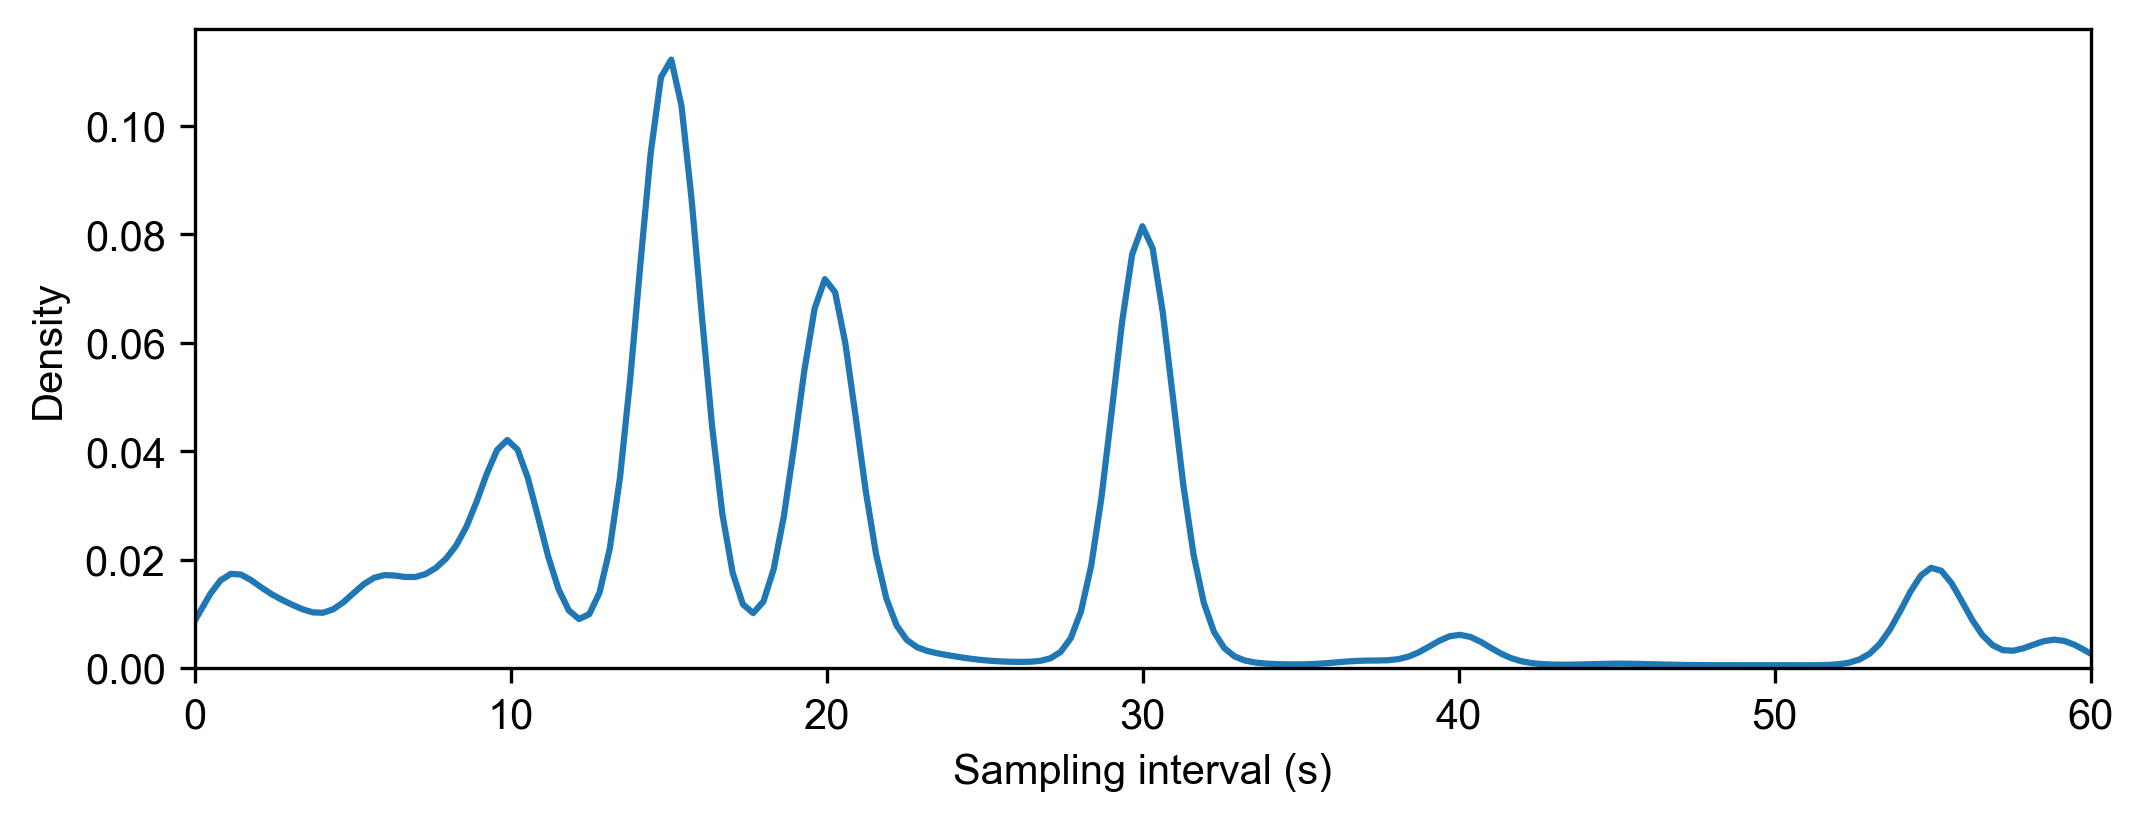

In [4]:
# Generate data quality report
tbd.data_summary(data,col=['id', 'time'],show_sample_duration=True)

## Redundancy Elimination

Redundancy elimination is an important step in cleaning trajectory data. It reduces the data volume and improves data processing efficiency without affecting the information contained in the data. In practical trajectory data processing, you may encounter the following two types of redundancy:

1. **Redundancy of Duplicate Data at the Same Moment**:

In a trajectory dataset, there may be multiple trajectory data entries for the same vehicle at the same moment. This can happen when the sampling interval is too short compared to the precision of the time field in the dataset. For example, if the sampling interval is 1 second, but the time field in the dataset has a precision of 1 minute, it can result in multiple trajectory data entries for the same vehicle within the same minute. Not removing these redundant data can cause difficulties in subsequent processing. The method to eliminate this redundancy is straightforward: keep only one trajectory data entry for the same vehicle at the same moment.

2. **Redundancy of Vehicle Stops**:

In vehicle trajectory data, the sampling interval is usually very short, such as collecting data every few seconds. This means that data is continuously generated for vehicles, whether they are moving or stationary. In practical applications, the focus is often on the trajectory of vehicles during trips, rather than during stops. For each instance of a vehicle stopping, we only need to know the start and end times of the stop. The data generated during the middle part of the stop, at the same location, is redundant and can be removed to reduce the overall data size. For a sequence of consecutive n data entries (n>=3) with the same location, we only need to keep the first and last entries, as the intermediate data is redundant. In the code, it is sufficient to compare the vehicle ID and the latitude-longitude of each data entry with the previous and next trajectory entries. If they are the same, the data can be removed.

However, the redundancy elimination method mentioned above for vehicle stops does not consider the information carried by fields other than the vehicle ID, time, and latitude-longitude. For example, in the case of taxi vehicles, passengers may board the taxi during a stop, changing the status from "vacant" to "occupied." In such cases, this information needs to be preserved.

TransBigData provides a function, `tbd.traj_clean_redundant()`, for trajectory data redundancy elimination. It can handle the mentioned redundancy situations and can also detect redundancy in fields other than the vehicle ID and latitude-longitude. The code is as follows:


In [5]:
# data volume before Redundancy Elimination
len(data)

544999

In [6]:
# Data redundancy removal to reduce data size and improve computational efficiency in subsequent steps
#
data = tbd.traj_clean_redundant(
    data,
    col=['id', 'time', 'lon', 'lat', 'speed']  # Apart from vehicle ID, time, longitude, and latitude, consider whether the speed field has redundancy
)
len(data)


421099

The code snippet performs data redundancy removal to reduce the data size and improve computational efficiency. The `traj_clean_redundant` function from the `tbd` module is used for this purpose. The function takes the `data` variable as input and specifies the columns (`col`) to consider for redundancy removal, including the vehicle ID, time, longitude, latitude, and optionally the speed field. The result is stored back in the `data` variable, and the length of the updated data is outputted.

## Drift Cleaning

In vehicle trajectory data, deviations and errors may occur between the collected vehicle trajectory data and the actual situations due to factors such as errors in data collection devices, environmental interferences, device malfunctions, unstable GPS signals, insufficient satellite coverage, and signal obstructions. This results in a discrepancy between the actual positions and the collected positions of the trajectory data, known as data drift in vehicle trajectory data. In the data, data drift is manifested by significant distances between the trajectory data points and the actual positions, often accompanied by sudden jumps. This drift can affect subsequent spatial analysis and spatial statistics, requiring the cleaning of vehicle trajectory data to ensure data accuracy and usability.

To clean vehicle trajectory data for drift, one approach is to remove trajectory data points outside the defined study area. The study area can be defined in two ways: either by specifying the bottom-left and top-right coordinates to determine the boundary range (bounds) or by using a geographic information file (geojson or shapefile) that represents the study area.

To remove drift data using a geojson or shapefile, you first need to read the geojson or shapefile as a `GeoDataFrame` type in GeoPandas. Then, you can use the `intersects()` method provided by GeoPandas to determine if the trajectory data is within the study area. However, this method requires performing spatial geometry matching for each trajectory data point, which can be time-consuming for large datasets. The `tbd.clean_outofshape()` method provided in the TransBigData package offers a more efficient approach. It first maps the trajectory data to the corresponding grid using built-in grid partitioning methods and then performs spatial matching based on the grid, significantly improving the cleaning efficiency.

Here is an example code snippet using TransBigData's `clean_outofshape()` method for data drift cleaning:

<AxesSubplot:>

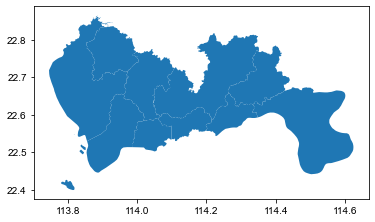

In [7]:
# Read the research area range
sz = gpd.read_file('Data/sz.json')
sz.plot()

In [8]:
# Data drift removal
# Removing data outside the study area
data = tbd.clean_outofshape(data, sz, col=['lon', 'lat'], accuracy=500)
len(data)


419448

Cleaning trajectory drift within the study area requires assessing and cleaning based on the continuous changes in trajectories. There are three common approaches for cleaning:

1. Velocity threshold method: If the velocity between the current trajectory data and the previous and subsequent trajectories exceeds a threshold, it is considered drift.
2. Distance threshold method: If the distance between the current trajectory data and the previous and subsequent trajectories exceeds a threshold, it is considered drift.
3. Angle threshold method: If the angle formed by the previous, current, and subsequent trajectories is smaller than a threshold, it is considered drift.

In TransBigData, the `tbd.traj_clean_drift()` method is provided to clean trajectory data for multiple vehicles. This method integrates distance, velocity, and angle thresholds into a single function.

Here is an example code snippet using TransBigData's `traj_clean_drift()` method:

In [9]:

# Drift cleaning within the study area using speed, distance, and angle as criteria
data = tbd.traj_clean_drift(
    data,  # Trajectory data, can include data for multiple vehicles, distinguished by ID
    col=['id', 'time', 'lon', 'lat'],  # Column names of the trajectory data
    speedlimit=80,  # Speed threshold in km/h, set to None to skip speed-based filtering
    dislimit=4000,  # Distance threshold in meters, set to None to skip distance-based filtering
    anglelimit=30)  # Angle threshold in degrees, set to None to skip angle-based filtering
len(data)


405286

## Stops and Trips Extracting

In long-term continuous observations of vehicle trajectory data, a common requirement is to extract the stops and trips from the trajectory data. The stops can be analyzed to determine the duration and location of the vehicle's parking, while the trips can be further analyzed to extract information such as the origin and destination of each trip, the travel path, travel duration, travel distance, and travel speed. In this section, we will explain how to identify stops and trips from vehicle trajectories, extract the trajectory information for each trip, and generate trajectory lines.

In vehicle trajectory data, stops and trips are typically identified using a time threshold method. The approach is as follows: to avoid fluctuations in the trajectory data, we need to predefine a grid in the geographical space. If the duration between two consecutive data points exceeds our set threshold (usually 30 minutes), we consider it as a stop. The time period between two stops is considered a trip, as shown in the figure below.

![StopsandTrips](./images/stops_and_trips.png "Stops and Trips")

After cleaning the trajectory data, we need to define a grid coordinate system and convert the trajectory data into grid-based representation to identify stops and trips.


In [11]:
# Define the grid parameters
bounds = [113.75, 22.4, 114.62, 22.86]
params = tbd.area_to_params(bounds,accuracy = 100)
params

{'slon': 113.75,
 'slat': 22.4,
 'deltalon': 0.0009743362892898221,
 'deltalat': 0.0008993210412845813,
 'theta': 0,
 'method': 'rect',
 'gridsize': 100}

The identification of stops and trips has been provided in the TransBigData package through the `tbd.traj_stay_move()` function. Here is the code:


In [12]:
# Identify stay and move
stay, move = tbd.traj_stay_move(data, params, col=['id', 'time', 'lon', 'lat'], activitytime=1800) 
len(stay), len(move)

(545, 725)

In the code, `data` represents the cleaned trajectory data. The `traj_stay_move()` function is used to identify stops and trips based on the specified stop threshold. It returns two outputs: `stops` and `trips`, which contain the identified stops and trips, respectively. You can utilize these data for further analysis.

Note: The `tbd.traj_stay_move()` function does not remove trips with a duration of 0. This is because some trajectory data may have long sampling intervals, which may not capture the travel process between two stops. As a result, the calculated duration for those trips would be 0.

In [13]:
stay

,id,stime,LONCOL,LATCOL,etime,lon,lat,duration,stayid
23320,22396,2023-05-29 06:10:09,262,284,2023-05-29 07:56:32,114.005547,22.655800,6383.0,0
51327,22396,2023-05-29 12:51:23,50,429,2023-05-29 16:44:57,113.798630,22.786167,14014.0,1
54670,22413,2023-05-29 00:00:09,145,431,2023-05-29 01:22:41,113.891403,22.787300,4952.0,2
54722,22413,2023-05-29 01:25:13,145,431,2023-05-29 02:01:44,113.891701,22.787399,2191.0,3
54741,22413,2023-05-29 02:18:13,145,431,2023-05-29 02:48:46,113.891502,22.787300,1833.0,4
...,...,...,...,...,...,...,...,...,...
151140,36686,2023-05-29 01:04:37,323,172,2023-05-29 02:33:37,114.065193,22.554672,5340.0,540
154762,36686,2023-05-29 03:03:07,307,185,2023-05-29 03:51:07,114.048721,22.566692,2880.0,541
154924,36686,2023-05-29 04:21:07,307,185,2023-05-29 05:06:07,114.048676,22.566605,2700.0,542
307421,36805,2023-05-29 03:15:54,324,168,2023-05-29 04:14:40,114.065552,22.551100,3526.0,543


In [14]:
move

,id,SLONCOL,SLATCOL,stime,slon,slat,etime,elon,elat,ELONCOL,ELATCOL,duration,moveid
0,22396,253,326,2023-05-29 00:00:29,113.996719,22.693333,2023-05-29 06:10:09,114.005547,22.655800,262.0,284.0,22180.0,0
23320,22396,262,284,2023-05-29 07:56:32,114.005547,22.655800,2023-05-29 12:51:23,113.798630,22.786167,50.0,429.0,17691.0,1
51327,22396,50,429,2023-05-29 16:44:57,113.798630,22.786167,2023-05-29 23:59:55,114.025253,22.654900,283.0,283.0,26098.0,2
54670,22413,145,431,2023-05-29 00:00:09,113.891403,22.787300,2023-05-29 00:00:09,113.891403,22.787300,145.0,431.0,0.0,3
54670,22413,145,431,2023-05-29 01:22:41,113.891403,22.787300,2023-05-29 01:25:13,113.891701,22.787399,145.0,431.0,152.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154762,36686,307,185,2023-05-29 03:51:07,114.048721,22.566692,2023-05-29 04:21:07,114.048676,22.566605,307.0,185.0,1800.0,720
154924,36686,307,185,2023-05-29 05:06:07,114.048676,22.566605,2023-05-29 23:53:46,114.124580,22.571978,384.0,191.0,67659.0,721
135725,36805,328,147,2023-05-29 00:00:03,114.070030,22.531967,2023-05-29 03:15:54,114.065552,22.551100,324.0,168.0,11751.0,722
307421,36805,324,168,2023-05-29 04:14:40,114.065552,22.551100,2023-05-29 04:23:40,114.066521,22.519133,325.0,132.0,540.0,723


Based on the stops and trips information, you can slice the trajectory data to extract the trajectory points during stops and trips. Since you have already performed redundancy elimination earlier, the redundant trajectory points during stops have been removed. As a result, the trajectory data during stops will have significantly fewer data points compared to the trajectory data during trips.

## Trajectory slicing

By the preceding code, parking and travel information has been successfully extracted from the data. However, in the obtained travel information, only the time, latitude, and longitude information of the starting and ending points of each trip are included, without the travel trajectory information. In order to further analyze the travel trajectories of vehicles, it is necessary to extract the trajectory data from the time periods of each trip, that is, slice the trajectory dataset based on the travel information. In the previously calculated travel information, each travel record has a travel ID, start time, and end time columns. The result of trajectory slicing is to extract the trajectory points during the trip and assign a travel ID label to each trajectory point.

The idea of trajectory slicing is illustrated in the diagram below. A flag column is created for the trajectory data to mark whether each row is within the desired time period for slicing. Then, each travel record in the travel data is decomposed into a start time record (flag label of 1) and an end time record (flag label of -1), which are inserted into the trajectory data. Next, the flag column is grouped and summed by vehicle to obtain the flag1 column. In the result, the rows where the flag1 column value is 1 (travel) and the flag column value is 0 (non-temporarily inserted data) are the desired trajectory data.

![trajslice](./images/trajslice.png "trajslice")

The code for slicing the trajectory data can be performed by using `tbd.traj_slice`, the code example is as follows:

In [18]:
# Extract trajectory points during parking
stay_points = tbd.traj_slice(data, stay, traj_col=['id', 'time'], slice_col=[
                             'id', 'stime', 'etime', 'stayid'])
stay_points

,id,time,lon,lat,OpenStatus,speed,stayid
23320,22396,2023-05-29 06:10:09,114.005547,22.655800,0.0,1.0,0.0
23321,22396,2023-05-29 06:20:42,114.005547,22.655800,0.0,0.0,0.0
23322,22396,2023-05-29 06:25:09,114.005417,22.655767,0.0,0.0,0.0
23323,22396,2023-05-29 06:25:17,114.005417,22.655767,0.0,0.0,0.0
23324,22396,2023-05-29 06:30:09,114.005402,22.655767,0.0,0.0,0.0
...,...,...,...,...,...,...,...
307425,36805,2023-05-29 04:14:40,114.066452,22.550966,0.0,9.0,543.0
337431,36805,2023-05-29 04:23:40,114.066521,22.519133,0.0,20.0,544.0
337432,36805,2023-05-29 04:23:55,114.066521,22.519133,0.0,0.0,544.0
337433,36805,2023-05-29 05:13:27,114.066521,22.519133,1.0,0.0,544.0


In [19]:
# Extract trajectory points during travel
move_points = tbd.traj_slice(data, move, traj_col=['id', 'time'], slice_col=[
                             'id', 'stime', 'etime', 'moveid'])
move_points

,id,time,lon,lat,OpenStatus,speed,moveid
0,22396,2023-05-29 00:00:29,113.996719,22.693333,1.0,20.0,0.0
27,22396,2023-05-29 00:01:01,113.995514,22.695032,1.0,34.0,0.0
28,22396,2023-05-29 00:01:09,113.995430,22.695766,1.0,41.0,0.0
29,22396,2023-05-29 00:01:41,113.995369,22.696484,1.0,0.0,0.0
30,22396,2023-05-29 00:02:21,113.995430,22.696650,1.0,17.0,0.0
...,...,...,...,...,...,...,...
132774,36805,2023-05-29 23:53:03,114.120354,22.544333,1.0,3.0,724.0
132775,36805,2023-05-29 23:53:09,114.120354,22.544300,1.0,2.0,724.0
132776,36805,2023-05-29 23:53:15,114.120354,22.544300,1.0,1.0,724.0
132777,36805,2023-05-29 23:53:21,114.120354,22.544300,1.0,0.0,724.0


## Trajectory densification and sparsification 

To facilitate subsequent tasks such as matching the travel paths in the trajectory data with the road network, we perform densification or sparsification of the trajectory points during the travel process. At this stage, we specify the ID column as the travel ID (moveid) column, meaning that when performing the densification or sparsification operation on the trajectory points, we consider each travel separately. The code for this operation is as follows:

In [59]:
# Trajectory densification
move_points_densified = tbd.traj_densify(
    move_points, col=['moveid', 'time', 'lon', 'lat'], timegap=15)
move_points_densified

,id,time,lon,lat,OpenStatus,speed,moveid
0,22396.0,2023-05-29 00:00:29,113.996719,22.693333,1.0,20.0,0.0
2,NaN,2023-05-29 00:00:30,113.996681,22.693386,NaN,NaN,0.0
3,NaN,2023-05-29 00:00:45,113.996116,22.694183,NaN,NaN,0.0
4,NaN,2023-05-29 00:01:00,113.995552,22.694979,NaN,NaN,0.0
1,22396.0,2023-05-29 00:01:01,113.995514,22.695032,1.0,34.0,0.0
...,...,...,...,...,...,...,...
397889,36805.0,2023-05-29 23:53:15,114.120354,22.544300,1.0,1.0,724.0
397890,36805.0,2023-05-29 23:53:21,114.120354,22.544300,1.0,0.0,724.0
4175974,NaN,2023-05-29 23:53:30,114.120354,22.544300,NaN,NaN,724.0
4175975,NaN,2023-05-29 23:53:45,114.120354,22.544300,NaN,NaN,724.0


In [60]:
# Trajectory sparsification
move_points_sparsified = tbd.traj_sparsify(
    move_points, col=['moveid', 'time', 'lon', 'lat'],  timegap=120)
move_points_sparsified

,id,time,lon,lat,OpenStatus,speed,moveid
0,22396,2023-05-29 00:00:29,113.996719,22.693333,1.0,20.0,0.0
4,22396,2023-05-29 00:02:21,113.995430,22.696650,1.0,17.0,0.0
7,22396,2023-05-29 00:04:21,113.992348,22.696733,0.0,36.0,0.0
10,22396,2023-05-29 00:06:21,113.986366,22.691000,0.0,48.0,0.0
12,22396,2023-05-29 00:08:21,113.989586,22.681749,0.0,43.0,0.0
...,...,...,...,...,...,...,...
397822,36805,2023-05-29 23:45:27,114.091217,22.540768,0.0,11.0,724.0
397835,36805,2023-05-29 23:47:21,114.093002,22.543383,1.0,0.0,724.0
397855,36805,2023-05-29 23:49:21,114.105850,22.545250,1.0,58.0,724.0
397875,36805,2023-05-29 23:51:21,114.119514,22.547033,1.0,24.0,724.0


In [ ]:
# define a function to plot the trajectory
def plot_traj(traj):
    import folium
    # 1. Create a map with the center at the average coordinates of the trajectory
    m = folium.Map(location=[traj['lat'].mean(), traj['lon'].mean()],  # Map center
                zoom_start=14,  # Map zoom level
                tiles='cartodbpositron')  # Map style
    # 2. Add the trajectory
    folium.PolyLine(
        traj[['lat', 'lon']].values.tolist(),  # Trajectory coordinates
        color='red',  # Trajectory color
        weight=2.5,  # Trajectory width
        opacity=1).add_to(m)  # Trajectory opacity, add to the map after creating the trajectory
    # 3. Add trajectory points
    for i in range(len(traj)):
        folium.CircleMarker(
            location=[traj['lat'].iloc[i], traj['lon'].iloc[i]],  # Trajectory point coordinates
            radius=3,  # Trajectory point radius
            color='red',  # Trajectory point color
        ).add_to(m)  # Fill opacity, add to the map after creating the trajectory point
    # 4. Add start and end markers
    folium.Marker([traj['lat'].iloc[0], traj['lon'].iloc[0]],  # Start point coordinates
                popup='Start',  # Start marker label
                icon=folium.Icon(color='green')).add_to(m)  # Start marker color
    folium.Marker([traj['lat'].iloc[-1], traj['lon'].iloc[-1]],
                popup='End',
                icon=folium.Icon(color='red')).add_to(m)
    # 5. Display the map, directly in Jupyter Notebook
    return m


In [65]:
moveid = 51
# Original trajectory
traj = move_points[move_points['moveid']==moveid]
plot_traj(traj)

In [66]:
# Densified trajectory
traj = move_points_densified[move_points_densified['moveid']==moveid]
plot_traj(traj)

In [67]:
# Sparsified trajectory
traj = move_points_sparsified[move_points_sparsified['moveid']==moveid]
plot_traj(traj)

## Trajectory smoothing

When processing vehicle trajectory data, the trajectory points represent "observations" of the actual "state" of the vehicle. Due to errors, the observed data may deviate from the actual state of the vehicle.

How can we obtain a more accurate estimation of the actual state of the vehicle? Consider the method mentioned in the previous section for detecting trajectory drift, which involves comparing the position of a trajectory point with the position of previous trajectory points to check for significant and unreasonable jumps. This approach is essentially based on predicting the possible future positions of the vehicle based on its previous trajectory. If the next recorded trajectory point deviates significantly from the expected position, it can be determined that the trajectory is abnormal.

This method shares similarities with the concept of Kalman filtering. Kalman filtering is a linear quadratic estimation algorithm used for state estimation in linear dynamic systems. It combines the previous state estimation (i.e., the predicted position of the current trajectory point) with the current observation data (recorded position of the current trajectory point) to obtain an optimal estimate of the current state.

The implementation of Kalman filtering involves predicting the current value using the previous optimal result and then correcting the current value using the observed value to obtain the optimal result. This method effectively reduces the impact of noise, allowing for a more accurate estimation of the actual state of the vehicle.

In [84]:
move_id =51
traj = move_points[move_points['moveid'] == move_id].copy()
traj_smoothed = tbd.traj_smooth(traj,col = ['id','time','lon', 'lat'],proj=False,process_noise_std = 0.01, measurement_noise_std = 1)

In [85]:
# plot the trajectory
import folium
m = folium.Map(location=[traj['lat'].mean(), traj['lon'].mean()], 
            zoom_start=14,  
            tiles='cartodbpositron')  
# original trajectory
folium.PolyLine(
    traj[['lat', 'lon']].values.tolist(),  
    color='red', 
    weight=2.5,
    opacity=1).add_to(m) 
# smoothed trajectory
folium.PolyLine(
    traj_smoothed[['lat', 'lon']].values.tolist(), 
    color='blue',
    weight=2.5, 
    opacity=1).add_to(m) 
m

The goal of the Kalman filter is to optimize the observed values by estimating the system state while considering the uncertainties of both the observation noise and the system dynamics. It has advantages in smoothing trajectory data by reducing noise effects and minimizing fluctuations within a small range. However, the Kalman filter cannot completely eliminate all noise or handle trajectory drift.

The Kalman filter is suitable for cases where the noise in the trajectory data is relatively stable, meaning the noise variance remains constant. It is particularly effective in smoothing small-scale fluctuations caused by measurement errors in trajectory data.

However, the effectiveness of the Kalman filter is limited when significant drift occurs in the trajectory. Drift points are treated as observations and have a significant impact on state estimation, which the Kalman filter cannot directly handle.

Furthermore, the Kalman filter requires the specification of covariance matrices for process and observation errors, and these parameter settings affect the smoothing effect. Improper covariance matrix settings can result in significant deviations in the smoothed trajectory data, especially when dealing with trajectory data that may deviate from the road network.

When processing trajectory data, a common approach is to first remove drift, then perform smoothing, and finally conduct road network matching. The rationale behind this approach is as follows:

- The drift removal step eliminates obvious drift points in the data, which are large noise components. The presence of drift points can significantly interfere with subsequent processing steps. Removing or correcting drift points ensures the accuracy and reliability of subsequent processing.
- After drift removal, the trajectory data may still contain some noise and fluctuations. To reduce the impact of these noise and fluctuations, smoothing can be applied to further process the trajectory data, making it smoother, more continuous, and maintaining the overall trend of the trajectory.
- Finally, the smoothed trajectory is more stable and better suited for road network matching. It reduces errors caused by noise and fluctuations, thereby improving the accuracy and reliability of road network matching.